#### Импорт необходимых библиотек и скриптов, настройка среды и шрифтов

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
matplotlib.rcParams.update({'font.size': 14})

#### Пути к файлам

In [2]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'
SUB_PATH = 'sample_submission.csv'

*Описание метрик датасета*
* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

#### Объявление класса и методов для подготовки данных

In [3]:
class Data:
    
    def __init__(self):
        
        self.Rooms_min = 1
        self.Rooms_max = 5

        self.Square_1 = 24
        self.Square_2 = 36
        self.Square_3 = 56
        self.Square_4 = 70
        self.Square_5 = 140

        self.LifeSquare_1 = 14
        self.LifeSquare_2 = 25
        self.LifeSquare_3 = 38
        self.LifeSquare_4 = 48
        self.LifeSquare_5 = 96
        
        self.KitchenSquare_1 = 5
        self.KitchenSquare_2 = 6
        self.KitchenSquare_3 = 8
        self.KitchenSquare_4 = 10
        self.KitchenSquare_5 = 20
        
        self.OddSquare_1 = 5
        self.OddSquare_2 = 5
        self.OddSquare_3 = 10
        self.OddSquare_4 = 12
        self.OddSquare_5 = 24

        #

        self.LifeSkoef_1 = (self.LifeSquare_2-self.LifeSquare_1)/(self.Square_2-self.Square_1)
        self.OddSkoef_1 = (self.OddSquare_2-self.OddSquare_1)/(self.Square_2-self.Square_1)
        self.KitchenSkoef_1 = (self.KitchenSquare_2-self.KitchenSquare_1)/(self.Square_2-self.Square_1)
        
        self.LifeSkoef_2 = (self.LifeSquare_3-self.LifeSquare_2)/(self.Square_3-self.Square_2)
        self.OddSkoef_2 = (self.OddSquare_3-self.OddSquare_2)/(self.Square_3-self.Square_2)
        self.KitchenSkoef_2 = (self.KitchenSquare_3-self.KitchenSquare_2)/(self.Square_3-self.Square_2)
        
        self.LifeSkoef_3 = (self.LifeSquare_4-self.LifeSquare_3)/(self.Square_4-self.Square_3)
        self.OddSkoef_3 = (self.OddSquare_4-self.OddSquare_3)/(self.Square_4-self.Square_3)
        self.KitchenSkoef_3 = (self.KitchenSquare_4-self.KitchenSquare_3)/(self.Square_4-self.Square_3)
        
        self.LifeSkoef_4 = (self.LifeSquare_5-self.LifeSquare_4)/(self.Square_5-self.Square_4)
        self.OddSkoef_4 = (self.OddSquare_5-self.OddSquare_4)/(self.Square_5-self.Square_4)
        self.KitchenSkoef_4 = (self.KitchenSquare_5-self.KitchenSquare_4)/(self.Square_5-self.Square_4)
        
        #
        
        self.HouseFloor_min = 1
        
        self.year_max = 2020
        
        self.medians_R = None
        self.medians_SR = None
        self.medians_LSR = None
        self.medians_KSR = None
        self.medians_OSR = None

        self.TVC_by_Dist = None # число предложений о продаже по районам
        self.AHY_by_Dist = None # средний возраст дома по районам
        self.AS_by_Dist = None # средняя общая площадь квартиры по районам
        self.HC1_by_Dist = None # среднее значение Healthcare_1 по районам
        self.SM_by_Dist_Price = None # стоимость жилья за квадратный метр по районам
        
        self.social_1_sum = None # сумма 1 
        self.social_2_sum = None # сумма 2 
        self.social_3_sum = None # сумма 3
        self.hab_by_unhab = None # соотношение жилой площади к нежилой

        
    def fit(self, train_df):
        
        # Медианы
        self.medians_R = train_df['Rooms'].median()
        self.medians_SR = train_df['Square'].median()/self.medians_R
        self.medians_LSR = train_df['LifeSquare'].median()/self.medians_R
        self.medians_KSR = train_df['KitchenSquare'].median()/self.medians_R
        self.medians_OSR = (train_df['Square'].median()-train_df['LifeSquare'].median()-train_df['KitchenSquare'].median())/self.medians_R
        
        # число предложений о продаже по районам
        self.TVC_by_Dist = train_df['DistrictId'].value_counts().to_dict()

        # средний возраст дома по районам
        self.AHY_by_Dist = train_df.groupby(['DistrictId'])['HouseYear'].agg('median').to_dict()
        
        # средняя общая площадь квартиры по районам
        self.AS_by_Dist = train_df.groupby(['DistrictId'])['Square'].agg('median').to_dict()
        
        # стоимость жилья за квадратный метр по районам
        self.SM_by_Dist_Price = train_df.groupby(['DistrictId'])[target_name].agg('median')/train_df.groupby(['DistrictId'])['Square'].agg('median')
        self.SM_by_Dist_Price.to_dict()
 
        # среднее значение признака Healthcare_1 по районам
        self.HC1_by_Dist = train_df.groupby(['DistrictId'])['Healthcare_1'].agg('mean').to_dict()


    def transform(self, train_df):
        
        #
        
        # Обработка квартир с числом комнат равным 0 или более self.Rooms_max
        train_df.loc[((train_df['Rooms'] < self.Rooms_min) | (train_df['Rooms'] > self.Rooms_max)) & (train_df['Square']<self.Square_2), ['Rooms']] = 1.0
        train_df.loc[((train_df['Rooms'] < self.Rooms_min) | (train_df['Rooms'] > self.Rooms_max)) & (train_df['Square']>=self.Square_2) & (train_df['Square']<self.Square_3), ['Rooms']] = 2.0
        train_df.loc[((train_df['Rooms'] < self.Rooms_min) | (train_df['Rooms'] > self.Rooms_max)) & (train_df['Square']>=self.Square_3) & (train_df['Square']<self.Square_4), ['Rooms']] = 3.0
        train_df.loc[((train_df['Rooms'] < self.Rooms_min) | (train_df['Rooms'] > self.Rooms_max)) & (train_df['Square']>=self.Square_4) & (train_df['Square']<self.Square_5), ['Rooms']] = 4.0
        train_df.loc[((train_df['Rooms'] < self.Rooms_min) | (train_df['Rooms'] > self.Rooms_max)) & (train_df['Square']>=self.Square_5), ['Rooms']] = 5.0

        #
        
        # Обработка квартир с пустыми значениями жилой площади
        train_df.loc[(train_df['LifeSquare'].isna() == True) & (train_df['Square']<self.Square_2), 'LifeSquare'] = self.LifeSquare_1
        train_df.loc[(train_df['LifeSquare'].isna() == True) & (train_df['Square']>=self.Square_2) & (train_df['Square']<self.Square_3), 'LifeSquare'] = self.LifeSquare_2
        train_df.loc[(train_df['LifeSquare'].isna() == True) & (train_df['Square']>=self.Square_3) & (train_df['Square']<self.Square_4), 'LifeSquare'] = self.LifeSquare_3
        train_df.loc[(train_df['LifeSquare'].isna() == True) & (train_df['Square']>=self.Square_4) & (train_df['Square']<self.Square_5), 'LifeSquare'] = self.LifeSquare_4
        train_df.loc[(train_df['LifeSquare'].isna() == True) & (train_df['Square']>=self.Square_5), 'LifeSquare'] = self.LifeSquare_5

        #
        
        # Обработка квартир с общей площадью менее self.Square_1
        train_df.loc[(train_df['Square']<self.Square_1) & (train_df['Rooms']==1.0), ['Square']] = self.Square_1
        train_df.loc[(train_df['Square']<self.Square_1) & (train_df['Rooms']==2.0), ['Square']] = self.Square_2
        train_df.loc[(train_df['Square']<self.Square_1) & (train_df['Rooms']==3.0), ['Square']] = self.Square_3
        train_df.loc[(train_df['Square']<self.Square_1) & (train_df['Rooms']==4.0), ['Square']] = self.Square_4
        train_df.loc[(train_df['Square']<self.Square_1) & (train_df['Rooms']>=5.0), ['Square']] = self.Square_5
        
        # Обработка квартир с общей площадью более self.Square_5
        train_df.loc[(train_df['Square']>self.Square_5) & (train_df['Rooms']==1.0), ['Square']] = self.Square_1
        train_df.loc[(train_df['Square']>self.Square_5) & (train_df['Rooms']==2.0), ['Square']] = self.Square_2
        train_df.loc[(train_df['Square']>self.Square_5) & (train_df['Rooms']==3.0), ['Square']] = self.Square_3
        train_df.loc[(train_df['Square']>self.Square_5) & (train_df['Rooms']==4.0), ['Square']] = self.Square_4
        train_df.loc[(train_df['Square']>self.Square_5) & (train_df['Rooms']>=5.0), ['Square']] = self.Square_5

        #
        
        # Обработка квартир с несоответствием площади и числа комнат
        train_df.loc[(train_df['Square']<self.Square_2) & (train_df['Rooms']>1), ['Rooms']] = 1.0
        train_df.loc[(train_df['Square']<self.Square_3) & (train_df['Rooms']>2), ['Rooms']] = 2.0
        train_df.loc[(train_df['Square']<self.Square_4) & (train_df['Rooms']>3), ['Rooms']] = 3.0
        train_df.loc[(train_df['Square']<self.Square_5) & (train_df['Rooms']>4), ['Rooms']] = 4.0
        
        #
        
        # Обработка квартир с площадью кухни менее 5 кв. м.
        train_df.loc[(train_df['KitchenSquare']<self.KitchenSquare_1) & (train_df['Rooms']==1.0), ['KitchenSquare']] = self.KitchenSquare_1
        train_df.loc[(train_df['KitchenSquare']<self.KitchenSquare_1) & (train_df['Rooms']==2.0), ['KitchenSquare']] = self.KitchenSquare_2
        train_df.loc[(train_df['KitchenSquare']<self.KitchenSquare_1) & (train_df['Rooms']==3.0), ['KitchenSquare']] = self.KitchenSquare_3
        train_df.loc[(train_df['KitchenSquare']<self.KitchenSquare_1) & (train_df['Rooms']==4.0), ['KitchenSquare']] = self.KitchenSquare_4
        train_df.loc[(train_df['KitchenSquare']<self.KitchenSquare_1) & (train_df['Rooms']>=5.0), ['KitchenSquare']] = self.KitchenSquare_5
 
        # Обработка квартир с жилой площадью менее 14 кв. м.
        train_df.loc[(train_df['LifeSquare']<self.LifeSquare_1) & (train_df['Rooms']==1.0), ['LifeSquare']] = self.LifeSquare_1
        train_df.loc[(train_df['LifeSquare']<self.LifeSquare_1) & (train_df['Rooms']==2.0), ['LifeSquare']] = self.LifeSquare_2
        train_df.loc[(train_df['LifeSquare']<self.LifeSquare_1) & (train_df['Rooms']==3.0), ['LifeSquare']] = self.LifeSquare_3
        train_df.loc[(train_df['LifeSquare']<self.LifeSquare_1) & (train_df['Rooms']==4.0), ['LifeSquare']] = self.LifeSquare_4
        train_df.loc[(train_df['LifeSquare']<self.LifeSquare_1) & (train_df['Rooms']>=5.0), ['LifeSquare']] = self.LifeSquare_5

        # Обработка 2-х и более комнатных квартир с жилой площадью менее 25 кв. м.
        train_df.loc[(train_df['LifeSquare']<self.LifeSquare_2) & (train_df['Rooms']==2), ['LifeSquare']] = self.LifeSquare_2
        train_df.loc[(train_df['LifeSquare']<self.LifeSquare_2) & (train_df['Rooms']==3), ['LifeSquare']] = self.LifeSquare_3
        train_df.loc[(train_df['LifeSquare']<self.LifeSquare_2) & (train_df['Rooms']==4), ['LifeSquare']] = self.LifeSquare_4
        train_df.loc[(train_df['LifeSquare']<self.LifeSquare_2) & (train_df['Rooms']>=5), ['LifeSquare']] = self.LifeSquare_5

        #
        
        # Обработка квартир с жилой площадью или площадью кухни как по отдельности, так в сумме больше общей площади
        train_df.loc[((train_df['Square']>=self.Square_1) & (train_df['Square']<self.Square_2)) &\
                 (train_df['LifeSquare']>(self.LifeSquare_1+round((train_df['Square']-self.Square_1)*(self.LifeSkoef_1)))) &\
                 ((train_df['LifeSquare'] + train_df['KitchenSquare'] + (self.OddSquare_1+round((train_df['Square']-self.Square_1)*(self.OddSkoef_1))))>train_df['Square']), ['LifeSquare']] = (self.LifeSquare_1+np.fix((np.fix(train_df['Square'])-self.Square_1)*(self.LifeSkoef_1)))
        train_df.loc[((train_df['Square']>=self.Square_1) & (train_df['Square']<self.Square_2)) &\
                 (train_df['KitchenSquare']>(self.KitchenSquare_1+round((train_df['Square']-self.Square_1)*(self.KitchenSkoef_1)))) &\
                 ((train_df['LifeSquare'] + train_df['KitchenSquare'] + (self.OddSquare_1+round((train_df['Square']-self.Square_1)*(self.OddSkoef_1))))>train_df['Square']), ['KitchenSquare']] = (self.KitchenSquare_1+np.fix((np.fix(train_df['Square'])-self.Square_1)*(self.KitchenSkoef_1)))

        train_df.loc[((train_df['Square']>=self.Square_2) & (train_df['Square']<self.Square_3)) &\
                 (train_df['LifeSquare']>(self.LifeSquare_2+round((train_df['Square']-self.Square_2)*(self.LifeSkoef_2)))) &\
                 ((train_df['LifeSquare'] + train_df['KitchenSquare'] + (self.OddSquare_2+round((train_df['Square']-self.Square_2)*(self.OddSkoef_2))))>train_df['Square']), ['LifeSquare']] = (self.LifeSquare_2+np.fix((np.fix(train_df['Square'])-self.Square_2)*(self.LifeSkoef_2)))
        train_df.loc[((train_df['Square']>=self.Square_2) & (train_df['Square']<self.Square_3)) &\
                 (train_df['KitchenSquare']>(self.KitchenSquare_2+round((train_df['Square']-self.Square_2)*(self.KitchenSkoef_2)))) &\
                 ((train_df['LifeSquare'] + train_df['KitchenSquare'] + (self.OddSquare_2+round((train_df['Square']-self.Square_2)*(self.OddSkoef_2))))>train_df['Square']), ['KitchenSquare']] = (self.KitchenSquare_2+np.fix((np.fix(train_df['Square'])-self.Square_2)*(self.KitchenSkoef_2)))

        train_df.loc[((train_df['Square']>=self.Square_3) & (train_df['Square']<self.Square_4)) &\
                 (train_df['LifeSquare']>(self.LifeSquare_3+round((train_df['Square']-self.Square_3)*(self.LifeSkoef_3)))) &\
                 ((train_df['LifeSquare'] + train_df['KitchenSquare'] + (self.OddSquare_3+round((train_df['Square']-self.Square_3)*(self.OddSkoef_3))))>train_df['Square']), ['LifeSquare']] = (self.LifeSquare_3+np.fix((np.fix(train_df['Square'])-self.Square_3)*(self.LifeSkoef_3)))
        train_df.loc[((train_df['Square']>=self.Square_3) & (train_df['Square']<self.Square_4)) &\
                 (train_df['KitchenSquare']>(self.KitchenSquare_3+round((train_df['Square']-self.Square_3)*(self.KitchenSkoef_3)))) &\
                 ((train_df['LifeSquare'] + train_df['KitchenSquare'] + (self.OddSquare_3+round((train_df['Square']-self.Square_3)*(self.OddSkoef_3))))>train_df['Square']), ['KitchenSquare']] = (self.KitchenSquare_3+np.fix((np.fix(train_df['Square'])-self.Square_3)*(self.KitchenSkoef_3)))
        
        train_df.loc[((train_df['Square']>=self.Square_4) & (train_df['Square']<=self.Square_5)) &\
                 (train_df['LifeSquare']>(self.LifeSquare_4+round((train_df['Square']-self.Square_4)*(self.LifeSkoef_4)))) &\
                 ((train_df['LifeSquare'] + train_df['KitchenSquare'] + (self.OddSquare_4+round((train_df['Square']-self.Square_4)*(self.OddSkoef_4))))>train_df['Square']), ['LifeSquare']] = (self.LifeSquare_4+np.fix((np.fix(train_df['Square'])-self.Square_4)*(self.LifeSkoef_4)))
        train_df.loc[((train_df['Square']>=self.Square_4) & (train_df['Square']<=self.Square_5)) &\
                 (train_df['KitchenSquare']>(self.KitchenSquare_4+round((train_df['Square']-self.Square_4)*(self.KitchenSkoef_4)))) &\
                 ((train_df['LifeSquare'] + train_df['KitchenSquare'] + (self.OddSquare_4+round((train_df['Square']-self.Square_4)*(self.OddSkoef_4))))>train_df['Square']), ['KitchenSquare']] = (self.KitchenSquare_4+np.fix((np.fix(train_df['Square'])-self.Square_4)*(self.KitchenSkoef_4)))
        
        #

        # Обработка квартир с неверно указанным годом постройки дома
        train_df.loc[(train_df['HouseYear'] > self.year_max), ['HouseYear']] = self.year_max

        # Приведение этажности дома в соответсвие с этажностью кварттир
        train_df.loc[(train_df['HouseFloor']<train_df['Floor']), 'HouseFloor'] = train_df['Floor']

        # Обработка dummy переменных заменой
        train_df.replace({'Ecology_2': {'A': 0, 'B': 1}}, inplace=True)
        train_df.replace({'Ecology_3': {'A': 0, 'B': 1}}, inplace=True)
        train_df.replace({'Shops_2': {'A': 0, 'B': 1}}, inplace=True)
        
        #
        
        # Заполнение пустых значений признака Healthcare_1 средним значением признака Healthcare_1 по районам      
        train_df.loc[train_df['Healthcare_1'].isna(), 'Healthcare_1'] = train_df['DistrictId'].map(self.HC1_by_Dist)
        train_df['Healthcare_1'].fillna(train_df['Healthcare_1'].median(), inplace=True)       
        
        return train_df

    
    def features(self, train_df):
        
        # Новый признак: средняя площадь на одну комнату в квартире
        train_df['feat_AvSq_by_Rooms'] = train_df['Square']/train_df['Rooms']
        # Новый признак: площадь вспомогательных помещений в квартире
        train_df['feat_OddSquare'] = train_df['Square']-train_df['LifeSquare']-train_df['KitchenSquare']
        # Новый признак: соотношение жилой площади к нежилой
        train_df['feat_LifeVsOdd'] = train_df['LifeSquare']/train_df['feat_OddSquare']
        # Новый признак: новостройка/вторичка
        train_df['feat_FirstSecond'] = np.select([(train_df['HouseYear']<(self.year_max-1)),
                                                   (train_df['HouseYear']>=(self.year_max-1))],
                                                  [1, 0])
        #
        # Новый признак: сумма значений dummy переменных Ecology_2 и Shops_2
        train_df['feat_2DumSum'] = train_df['Ecology_2']+train_df['Shops_2']
        # Новый признак: сумма социальных признаков Social_2 и Healthcare_1
        train_df['feat_Soc2Health1Sum'] = train_df['Social_2']+train_df['Healthcare_1']
        # Новый признак: сумма социальных признаков Social_1 и Social_3
        train_df['feat_Soc1Soc3Sum'] = train_df['Social_1']+train_df['Social_3']
        # Новый признак: сумма социальных признаков Healthcare_2 и Shops_1
        train_df['feat_Health2Sh1Sum'] = train_df['Helthcare_2']+train_df['Shops_1']
        # Новый признак: сумма социальных признаков Social_1 и Shops_1
        train_df['feat_Soc1Sh1Sum'] = train_df['Social_1']+train_df['Shops_1']
        # Новый признак: сумма социальных признаков
        train_df['feat_AllSocSum'] = train_df['Social_1']+train_df['Social_2']+train_df['Social_3']+train_df['Healthcare_1']+train_df['Helthcare_2']+train_df['Shops_1']
        #
        # Новый признак: скалированное объединение социальных признаков
        scaler = RobustScaler()
        pca = PCA(n_components=1, random_state=42)
        social_scaled = pd.DataFrame(scaler.fit_transform(train_df[['Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1']]))
        train_df['feat_Social'] = pca.fit_transform(social_scaled)
        # Новый признак: число предложений о продаже по районам
        train_df['feat_DistrictIdCounts'] = train_df['DistrictId'].map(self.TVC_by_Dist)
        train_df['feat_DistrictIdCounts'].fillna(train_df['feat_DistrictIdCounts'].median(), inplace=True)
        # Новый признак: средний возраст дома по районам
        train_df['feat_DistrictYear'] = train_df['DistrictId'].map(self.AHY_by_Dist)
        train_df['feat_DistrictYear'].fillna(train_df['feat_DistrictYear'].median(), inplace=True)
        # Новый признак: средняя общая площадь квартиры по районам
        train_df['feat_DistrictSquare'] = train_df['DistrictId'].map(self.AS_by_Dist)
        train_df['feat_DistrictSquare'].fillna(train_df['feat_DistrictSquare'].median(), inplace=True)
        # Новый признак: стоимость жилья за квадратный метр по районам
        train_df['feat_DistrictPrice'] = train_df['DistrictId'].map(self.SM_by_Dist_Price)
        train_df['feat_DistrictPrice'].fillna(train_df['feat_DistrictPrice'].median(), inplace=True)
        
        return train_df


#### Объявление функции для вывода предсказаний

In [4]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

#### Загрузка датасетов

In [5]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

#### Таргет

In [6]:
target_name = 'Price'
y = train_df[target_name]

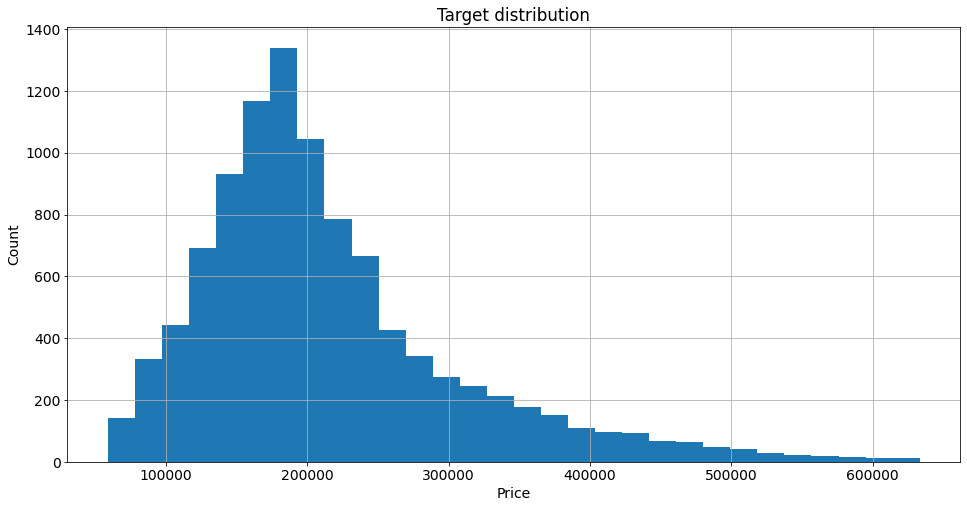

In [7]:
plt.figure(figsize = (16, 8))

y.hist(bins=30)
plt.ylabel('Count')
plt.xlabel(target_name)

plt.title('Target distribution')
plt.show()

#### Тренировочный датасет

In [8]:
train_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [10]:
train_df.isna().sum().to_frame(name="nans").query("nans > 0")["nans"]

LifeSquare      2113
Healthcare_1    4798
Name: nans, dtype: int64

In [11]:
train_df.eq(0).sum()

Id                  1
DistrictId         48
Rooms               8
Square              0
LifeSquare          0
KitchenSquare     697
Floor               0
HouseFloor        269
HouseYear           0
Ecology_1         537
Ecology_2           0
Ecology_3           0
Social_1          201
Social_2            0
Social_3         2997
Healthcare_1        1
Helthcare_2      4214
Shops_1          2316
Shops_2             0
Price               0
dtype: int64

In [12]:
train_df.nunique()

Id               10000
DistrictId         205
Rooms                9
Square           10000
LifeSquare        7887
KitchenSquare       58
Floor               33
HouseFloor          44
HouseYear           97
Ecology_1          129
Ecology_2            2
Ecology_3            2
Social_1            51
Social_2           142
Social_3            30
Healthcare_1        79
Helthcare_2          7
Shops_1             16
Shops_2              2
Price            10000
dtype: int64

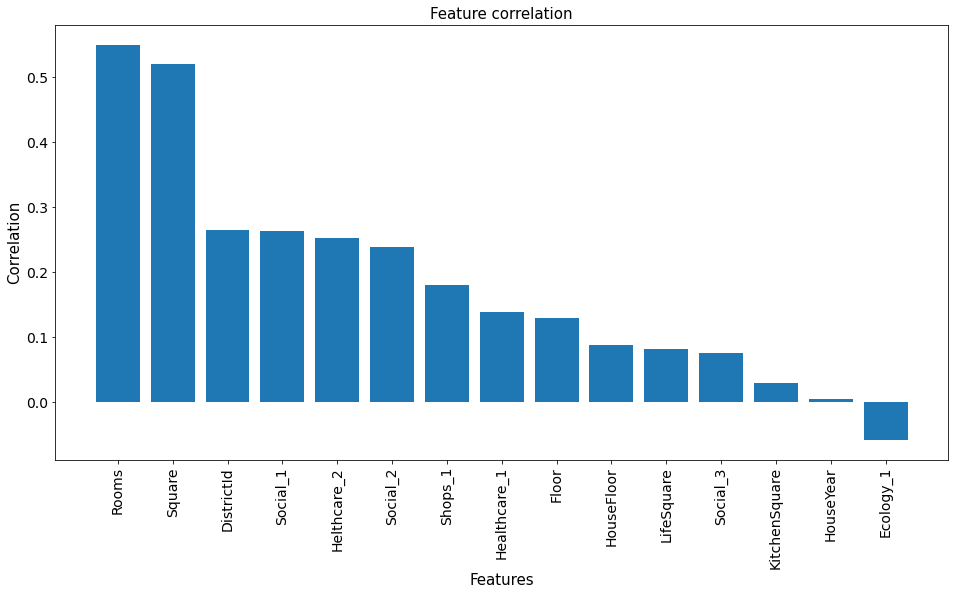

In [13]:
correlation = train_df.corrwith(y).sort_values(ascending=False)
correlation.drop(['Id', target_name], inplace=True)

plt.figure(figsize = (16, 8))
plt.bar(correlation.index, correlation)
plt.xticks(rotation='90')
plt.xlabel('Features', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
plt.title('Feature correlation', fontsize=15)
plt.show()

### EDA

#### Статистика

In [14]:
train_df.describe(percentiles=[.05, .5, .95])

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
5%,819.95000,1.000000,1.000000,34.168758,17.694948,0.000000,2.000000,1.000000,1.961000e+03,0.000000,1.000000,264.000000,0.000000,30.000000,0.000000,0.000000,99109.468628
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
95%,15933.10000,139.000000,3.000000,87.847047,68.277001,12.000000,18.000000,24.000000,2.017000e+03,0.371149,53.000000,13670.000000,39.000000,2890.000000,4.000000,15.000000,408532.364581
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [15]:
ft_bp = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear']
p1 = 5
p3 =95
for column in ft_bp:
    print('\033[1m' + f'{column}:' + '\033[0m')
    Q1 = train_df[column].quantile(0.5)
    print(f'Q1 = {Q1}' )
    Q3 = train_df[column].quantile(0.95)
    print(f'Q3 = {Q3}')
    IQR = Q3 - Q1
    print(f'IQR =  {IQR}')
    min1 = Q1 - (1.5 * IQR)
    max3 = Q3 + (1.5 * IQR)
    print('\nOutliers:')
    print(f'{train_df.loc[((train_df[column]<min1) | (train_df[column]>max3)), [column]].value_counts()}\n')

Rooms:
Q1 = 2.0
Q3 = 3.0
IQR =  1.0

Outliers:
Rooms
5.0      18
0.0       8
10.0      2
6.0       1
19.0      1
dtype: int64

Square:
Q1 = 52.51330992401352
Q3 = 87.8470473853468
IQR =  35.33373746133328

Outliers:
Square    
147.709302    1
170.016872    1
604.705972    1
409.425181    1
275.645284    1
212.932361    1
200.334539    1
198.930182    1
190.857689    1
186.692602    1
185.906396    1
183.382273    1
174.649522    1
170.379494    1
169.509941    1
148.179026    1
169.385184    1
169.117203    1
168.086347    1
167.767027    1
163.495333    1
163.286965    1
162.587886    1
160.647588    1
156.636577    1
155.930023    1
151.150660    1
148.671938    1
641.065193    1
dtype: int64

LifeSquare:
Q1 = 32.781260192155735
Q3 = 68.27700073931355
IQR =  35.495740547157816

Outliers:
LifeSquare 
122.497641     1
123.139863     1
638.163193     1
461.463614     1
410.639749     1
263.542020     1
233.949309     1
211.231125     1
201.627361     1
174.837082     1
170.713651     1


#### **Обрабатываемые данные:**
* **HouseYear** - две квартиры с ошибочным значением года постройки дома
* **Rooms** - квартиры с числом комнат больше 5 или равным 0
* **LifeSquare** - квартиры с неуказанной жилой площадью
* **Healthcare_1** - квартиры с неуказанным параметром Healthcare_1
* **Square** - квартиры с общей площадью меньше нормативных значений
* **LifeSquare** и **KitchenSquare** - квартиры с жилой площадью или площадью кухни меньше нормативных значений
* **LifeSquare** и **KitchenSquare** - квартиры с жилой площадью или площадью кухни как по отдельности, так в сумме больше общей площади
* **HouseFloor** и **Floor** - квартиры с этажностью больше этажности дома
* **Ecology_2**, **Ecology_3**, **Shops_2** - dummy переменные


#### Разделение и обработка данных

In [16]:
X = train_df.copy()

In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=100)

In [18]:
data_inst = Data()

data_inst.fit(X_train)
X_train = data_inst.transform(X_train)
X_valid = data_inst.transform(X_valid)
test_df = data_inst.transform(test_df)

In [19]:
X_train.shape, X_valid.shape, test_df.shape

((8000, 20), (2000, 20), (5000, 19))

In [20]:
data_inst.fit(X_train)
X_train = data_inst.features(X_train)
X_valid = data_inst.features(X_valid)
test_df = data_inst.features(test_df)

In [21]:
X_train.shape, X_valid.shape, test_df.shape

((8000, 35), (2000, 35), (5000, 34))

In [24]:
# Оставляем все признаки

X_train.drop(['Id', target_name], axis=1, inplace=True)
X_valid.drop(['Id', target_name], axis=1, inplace=True)
test_df.drop(['Id'], axis=1, inplace=True)

In [25]:
X_train.shape, test_df.shape, X_valid.shape

((8000, 33), (5000, 33), (2000, 33))

In [26]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

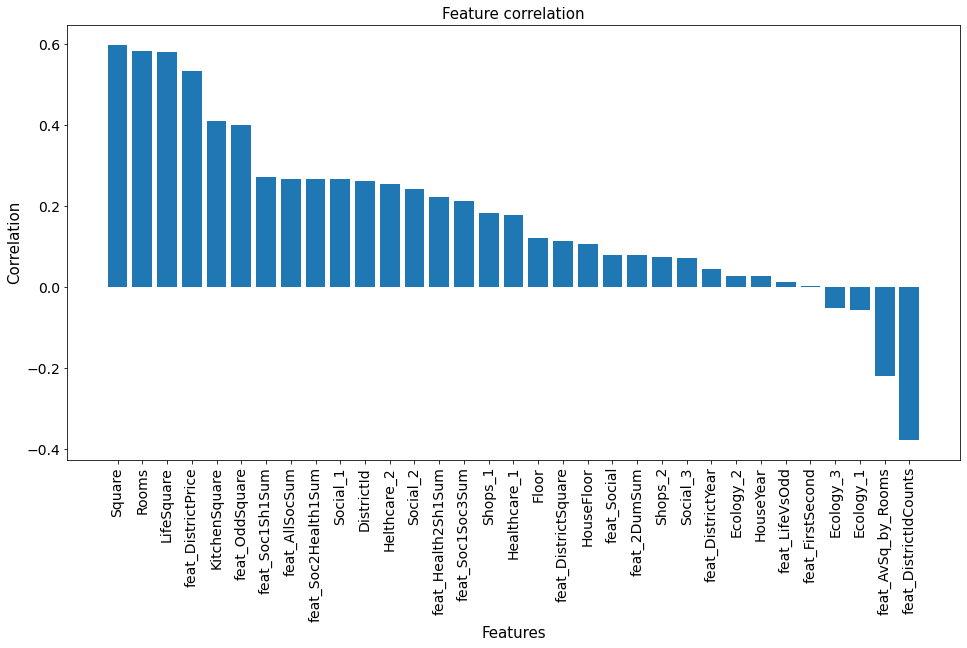

In [27]:
correlation = X_train.corrwith(y).sort_values(ascending=False)

plt.figure(figsize = (16, 8))
plt.bar(correlation.index, correlation)
plt.xticks(rotation='90')
plt.xlabel('Features', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
plt.title('Feature correlation', fontsize=15)
plt.show()

In [29]:
X_train.describe(percentiles=[.05, .5, .95])

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,feat_AvSq_by_Rooms,feat_OddSquare,feat_LifeVsOdd,feat_FirstSecond,feat_2DumSum,feat_Soc2Health1Sum,feat_Soc1Soc3Sum,feat_Health2Sh1Sum,feat_Soc1Sh1Sum,feat_AllSocSum,feat_Social,feat_DistrictIdCounts,feat_DistrictYear,feat_DistrictSquare,feat_DistrictPrice
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.00000,8000.000000,8000.000000,8000.00000,8000.000000,8000.000000,8000.000000,8000.000000,8000.00000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8.000000e+03,8000.000000,8000.000000,8000.000000,8000.000000
mean,50.597125,1.868000,55.845271,33.309913,7.22225,8.544875,13.448250,1984.88825,0.118203,0.990125,0.972500,24.593625,5333.29775,8.023500,975.496983,1.316500,4.217375,0.916125,32.468096,15.313109,2.417944,0.990250,1.906250,6308.794733,32.617125,5.533875,28.811000,6346.945733,-3.446132e-16,195.623250,1978.312125,52.932405,3826.523973
std,43.746892,0.793665,18.166069,11.784888,2.22912,5.252398,6.113448,18.46086,0.118948,0.098887,0.163545,17.543644,4001.84852,23.747957,905.481484,1.494275,4.807157,0.277218,9.336072,7.820921,0.798498,0.098266,0.297022,4220.475000,29.890085,5.673150,20.493426,4243.035590,4.800874e+00,218.016589,9.575345,6.220000,997.703820
min,0.000000,1.000000,24.000000,14.000000,5.00000,1.000000,1.000000,1910.00000,0.000000,0.000000,0.000000,0.000000,168.00000,0.000000,0.000000,0.000000,0.000000,0.000000,17.500000,4.944786,0.128853,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,168.000000,-1.776630e+00,1.000000,1917.000000,34.764523,2099.023202
5%,1.000000,1.000000,34.112196,18.482801,5.00000,2.000000,5.000000,1961.00000,0.000000,1.000000,1.000000,1.000000,264.00000,0.000000,0.000000,0.000000,0.000000,0.000000,20.842799,6.785925,1.108413,1.000000,1.000000,494.697674,1.000000,0.000000,2.000000,496.697674,-1.758075e+00,10.000000,1965.000000,43.824842,2099.023202
50%,36.000000,2.000000,52.298355,31.490151,6.00000,7.000000,14.000000,1977.00000,0.072158,1.000000,1.000000,25.000000,5285.00000,2.000000,750.000000,1.000000,3.000000,1.000000,30.814106,13.533918,2.401011,1.000000,2.000000,6207.000000,31.000000,5.000000,29.000000,6247.000000,-1.224935e+00,81.000000,1977.000000,53.621819,3984.281339
95%,140.000000,3.000000,87.372998,53.000000,11.00000,18.000000,24.000000,2017.00000,0.371149,1.000000,1.000000,53.000000,13670.00000,39.000000,2715.000000,4.000000,15.000000,1.000000,47.200241,28.804015,3.731787,1.000000,2.000000,14218.600000,76.000000,17.000000,62.000000,14281.900000,6.149406e+00,685.000000,2000.000000,62.023293,5309.808704
max,208.000000,5.000000,140.000000,100.985505,32.00000,37.000000,117.000000,2020.00000,0.521867,1.000000,1.000000,74.000000,19083.00000,141.000000,4849.000000,6.000000,23.000000,1.000000,136.727224,108.651237,5.055459,1.000000,2.000000,20489.000000,163.000000,26.000000,89.000000,20585.000000,2.685893e+01,685.000000,2010.500000,87.962242,8593.064137


* **Модель CatBoostRegressor**

In [30]:
cb_model = CatBoostRegressor(
    silent=True,
    learning_rate=0.1,
    iterations=1150,
    eval_metric='R2',
    depth=8
)

In [31]:
# grid = {'learning_rate': [0.03, 0.1],
#         'depth': [2, 4, 6, 8],
#         'l2_leaf_reg': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

In [32]:
# grid_search_result = cb_model.grid_search(grid, X=X_train, y=y_train, plot=True)

In [33]:
cb_model.fit(X_train, y_train)
#cb_model.fit(X_train, y_train, verbose=False, plot=True)

Train R2:	0.982
Test R2:	0.74


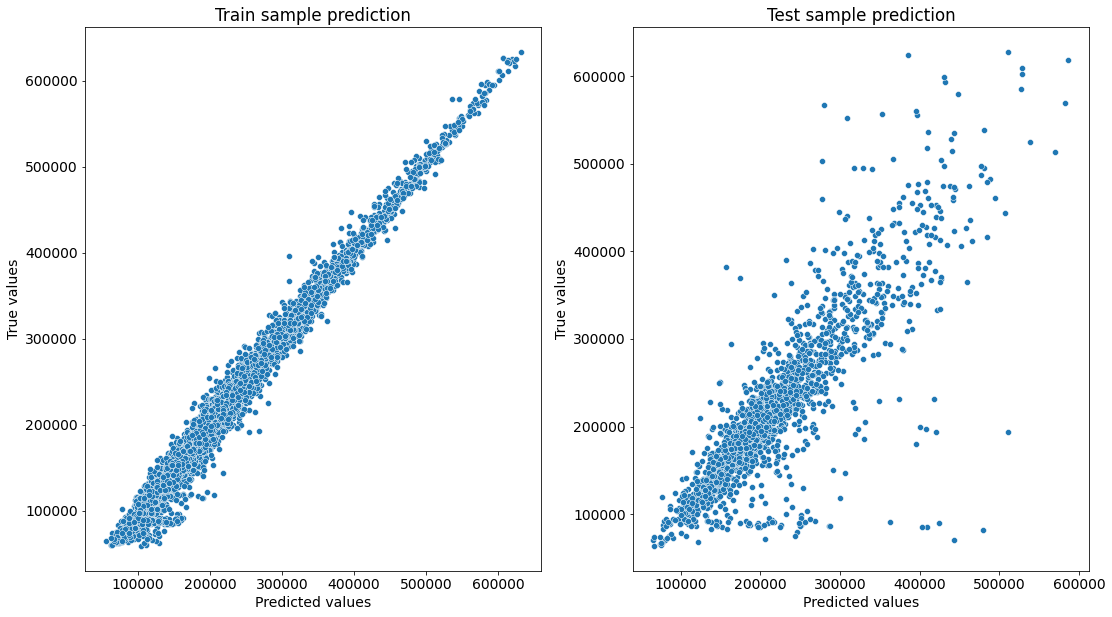

In [34]:
# Оценка модели

y_train_preds = cb_model.predict(X_train)
y_test_preds = cb_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [35]:
# Кросс-валидация

cv_score = cross_val_score(cb_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=100))

In [36]:
cv_score

array([0.76141106, 0.76089983, 0.7216478 ])

In [37]:
cv_score.mean()

0.7479862324802703

In [38]:
# Важность признаков

feature_importances = pd.DataFrame(zip(X_train.columns, cb_model.get_feature_importance()), columns=['feature_name', 'importance'])
feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances

,feature_name,importance
2,Square,20.416064
32,feat_DistrictPrice,18.705419
7,HouseYear,6.029370
3,LifeSquare,4.352574
18,feat_AvSq_by_Rooms,4.252522
4,KitchenSquare,3.936455
5,Floor,3.713111
19,feat_OddSquare,3.648505
6,HouseFloor,3.444825
31,feat_DistrictSquare,2.966144


#### Прогнозирование

In [39]:
submit_cb = pd.read_csv(SUB_PATH)
submit_cb.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [40]:
predictions_cb = cb_model.predict(test_df)
predictions_cb

array([172847.89424964, 118353.25897542, 147544.58775718, ...,
       146776.02644282, 194491.05600835, 255110.22637869])

In [41]:
submit_cb['Price'] = predictions_cb
submit_cb.head()

,Id,Price
0,4567,172847.894250
1,5925,118353.258975
2,960,147544.587757
3,3848,105530.710811
4,746,177640.386372


In [43]:
submit_cb.to_csv('cb1kag_submit.csv', index=False, encoding='utf-8', sep=',')